# Heart Failure Prediction

The goal of this is to find a good model that can predict if a person has a heart disease given some data. In this notebook we are going to explore and analyse the heart dataset and make some feature engineering. The dataset used in this project is obtained from https://www.kaggle.com/fedesoriano/heart-failure-prediction

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, plot_roc_curve, plot_confusion_matrix

from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from skopt import BayesSearchCV

from skopt.space import Integer, Real, Categorical

import pickle

from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [10]:
heart_df = pd.read_csv('../data/heart.csv')
print(heart_df.shape)
heart_df

(918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Renaming the columns to make them easier to read

In [11]:
column_names = ["age", "sex", "pain", "blood_preassure", "cholesterol", "blood_sugar", "resting_ecg", "max_hr", 
                "angina", "old_peak", "slope", "heart_disease"]
heart_df.columns = column_names

### Splitting into train and test set

To avoid randomness and have the same train and test sets regardess of the version of a library or rand seed, we are using the row index to create our sets. If the modulus of the id is greater or equal than 8 it will belong to the test set, in this case, we are going to be able to create a deterministic partitions

In [12]:
train_set, test_set = train_test_split(heart_df, random_state=512)

In [13]:
train_set.shape

(688, 12)

In [14]:
test_set.shape

(230, 12)

## Analysing the data

First, lets see the data types of our features

In [15]:
train_set.dtypes

age                  int64
sex                 object
pain                object
blood_preassure      int64
cholesterol          int64
blood_sugar          int64
resting_ecg         object
max_hr               int64
angina              object
old_peak           float64
slope               object
heart_disease        int64
dtype: object

Looking for missing values

In [16]:
features_with_na = [feature for feature in train_set.columns if train_set[feature].isnull().mean() > 0]
features_with_na

[]

Great, its seems we dont have missing data. Now, lets take a look of the correlation matrix

<AxesSubplot:>

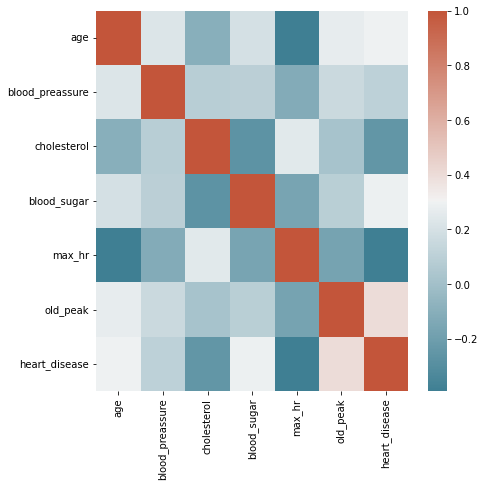

In [17]:
corrmat = train_set.corr(method='pearson')

# we can make a heatmap with the package seaborn
# and customise the colours of searborn's heatmap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# some more parameters for the figure
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)

# and now plot the correlation matrix
sns.heatmap(corrmat, cmap=cmap)

### Getting the labels

In [18]:
# all the columns but the label
X_train = train_set.drop('heart_disease', axis=1)
X_test = test_set.drop('heart_disease', axis=1)

# just the label
Y_train = train_set['heart_disease']
Y_test = test_set['heart_disease']

In [19]:
numerical_features = [column for column in X_train.columns if X_train[column].dtype != object]
numerical_features

['age', 'blood_preassure', 'cholesterol', 'blood_sugar', 'max_hr', 'old_peak']

In [20]:
categorical_features = [column for column in X_train.columns if X_train[column].dtype == object]
categorical_features

['sex', 'pain', 'resting_ecg', 'angina', 'slope']

### Numerical data

Now, we are going to analyse the numerical variables of our train set

In [21]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(16, 4))
    plt.title(variable)
    
    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=50)
    plt.title('Histogram')
    
    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)
    plt.ylabel('RM quantiles')
    
    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.suptitle(variable)

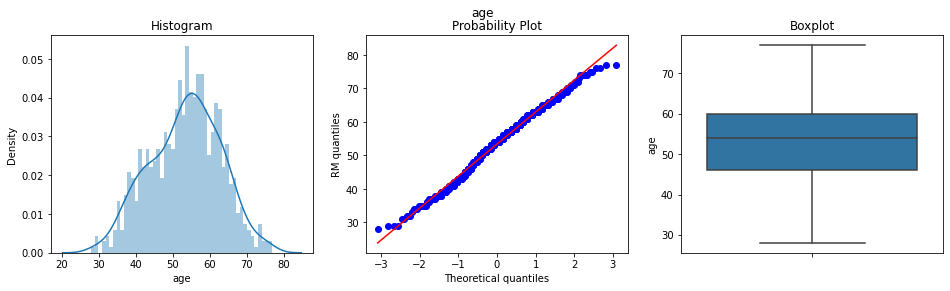

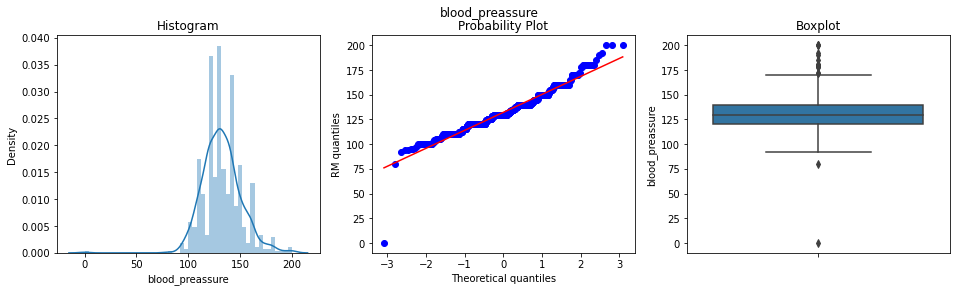

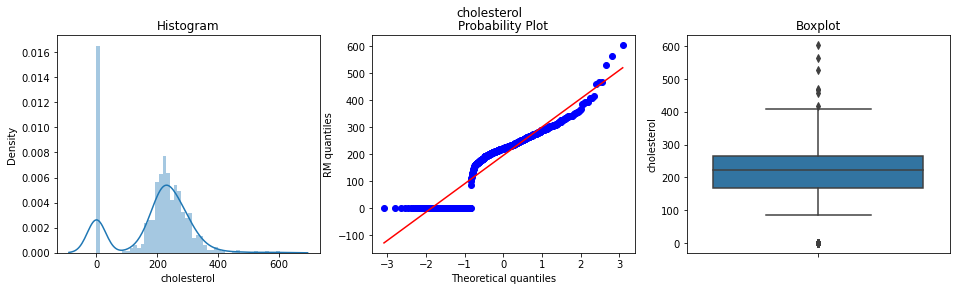

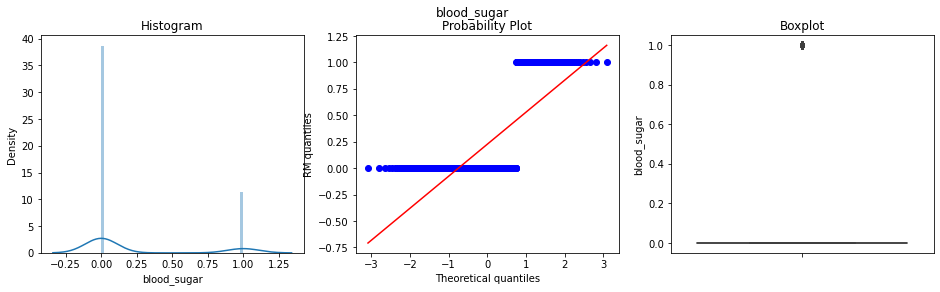

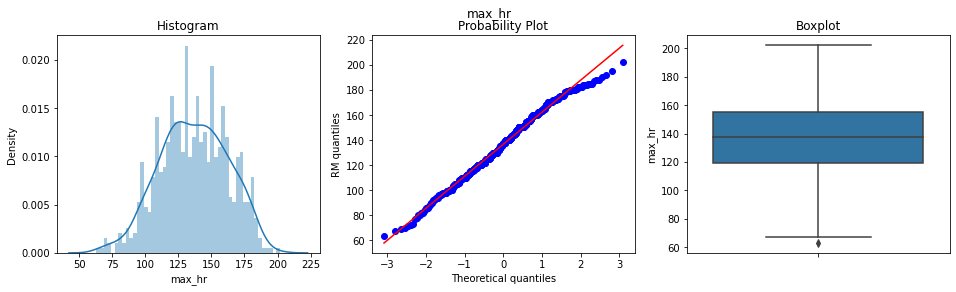

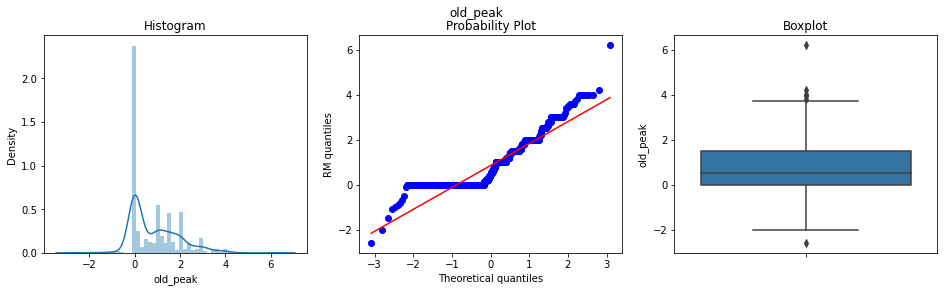

In [22]:
for feature in numerical_features:
    diagnostic_plots(train_set, feature)

As we can see, the bood_sugar variable is a binary variable, se we have to move it to the categorical variables

In [23]:
del numerical_features[3]
categorical_features.append('blood_sugar')

### Categorical data

Getting the cardinality of the categorical features

In [24]:
for feature in categorical_features:
    print(f'{feature} - number of values: {X_train[feature].nunique()}')

sex - number of values: 2
pain - number of values: 4
resting_ecg - number of values: 3
angina - number of values: 2
slope - number of values: 3
blood_sugar - number of values: 2


Inspecting the distribution of those labels

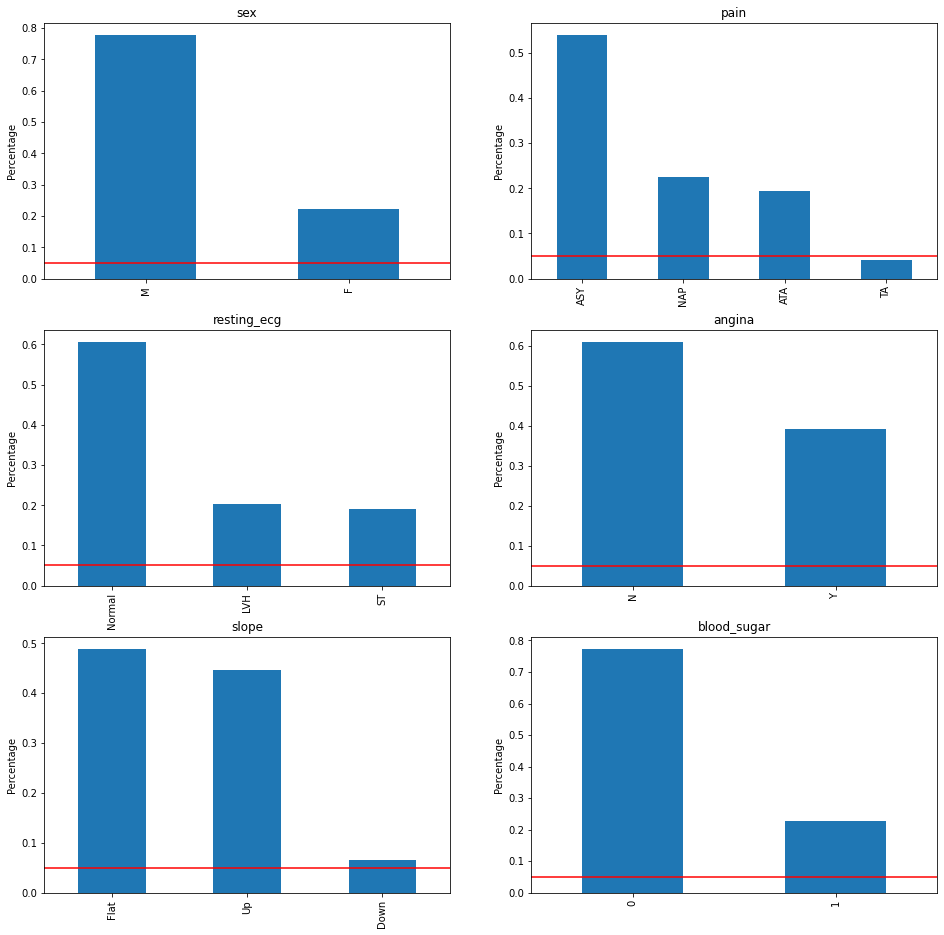

In [25]:
fig = plt.figure(figsize=(16, 16))

columns = 2
rows = 3

for i, feature in enumerate(categorical_features):
    temp_df = pd.Series(X_train[feature].value_counts() / len(X_train))
    
    fig.add_subplot(rows, columns, i + 1)
    
    bar = temp_df.sort_values(ascending=False).plot.bar()
    bar.set_title(feature)

    # The 5% line is to mark the uncommon labels
    bar.axhline(y=0.05, color='red')
    bar.set_ylabel('Percentage')

plt.show()

### The label

Now, lets analyse the labels to see how balanced is

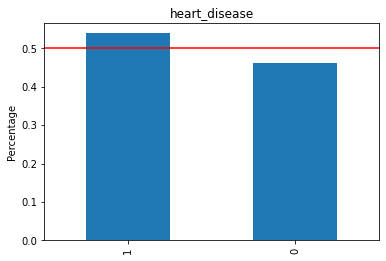

In [26]:
temp_df = pd.Series(Y_train.value_counts() / len(Y_train))
bar = temp_df.sort_values(ascending=False).plot.bar()
bar.set_title("heart_disease")
bar.axhline(y=0.5, color='red')
bar.set_ylabel('Percentage')
plt.show()

## Feature engineering

### Looking and removing constant and quasi constant features

In [27]:
features = []

# iterate over every feature to find if it is a constant or a quasi constant
for feature in X_train.columns:
    
    # find the value that is shared by most of the observations
    predominant = (X_test[feature].value_counts() / float(len(X_train))) \
            .sort_values(ascending=False).values[0]
    
    if predominant > 0.98:
        features.append(feature)

features

[]

So, we are not going to delete any feature because none of them are constants nor quasi constants. Now, lets manage the outliers

In [28]:
numerical_pipeline = Pipeline([
    ("transform", PowerTransformer())
])

categorical_pipeline = Pipeline([
    ("one_hot_encoder", OneHotEncoder(drop='first'))
])

feature_engineer_pipeline = ColumnTransformer([
    ("transform", numerical_pipeline, numerical_features),
    ("one_hot_encoder", categorical_pipeline, categorical_features)
])

X_train_transformed = feature_engineer_pipeline.fit_transform(X_train)
X_test_transformed = feature_engineer_pipeline.transform(X_test)

# Transforming the labels into numpy arrays
Y_train = Y_train.values
Y_test = Y_test.values

In [29]:
X_train_df = pd.DataFrame(X_train)

X_train_df.describe()

,age,blood_preassure,cholesterol,blood_sugar,max_hr,old_peak
count,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,53.395349,132.194767,195.912791,0.226744,136.680233,0.852035
std,9.564800,18.572408,111.746938,0.419030,25.565216,1.053556
min,28.000000,0.000000,0.000000,0.000000,63.000000,-2.600000
25%,46.000000,120.000000,166.750000,0.000000,119.000000,0.000000
50%,54.000000,130.000000,222.000000,0.000000,137.500000,0.500000
75%,60.000000,140.000000,265.250000,0.000000,155.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000


## Train and optimize a model

In [22]:
models = [
    (
        "logistic_regression",
        LogisticRegression(n_jobs=-1),
        {
            "C": Real(2, 6),
            "max_iter": Integer(300, 1500)
        }
    ),
    
    (
        "linear_SVM",
        LinearSVC(),
        {
            "C": Real(1e-5, 100),
            "max_iter": Integer(5000, 7500)
        }
    ),
    
    (
        "decision_tree",
        DecisionTreeClassifier(),
        {
            "max_depth": Integer(5, 15)
        }
    ),
    
    (
        "SVM",
        SVC(),
        {
            "C": Real(2, 6),
            "gamma": Real(1, 10)
        }
    ),
    
    (
        "nerual_network",
        MLPClassifier(early_stopping=True, n_iter_no_change=30, max_iter=5000, solver="lbfgs"),
        {
            "hidden_layer_sizes": Integer(80, 512),
            "learning_rate_init": Real(1e-5, 1e-2)}),
    
    (
        "XGB",
        XGBClassifier(n_jobs=-1, verbosity=0, use_label_encoder=False),
        {
            "n_estimators": Integer(20, 1000),
            "learning_rate": Real(0.0001, 1)}),
    
    (
        "adaboost",
        AdaBoostClassifier(),
        {
            "n_estimators": Integer(20, 100),
            "learning_rate": Real(0.0001, 1)
        }
    ),
    
    (
        "random_forest",
        RandomForestClassifier(n_jobs=-1),
        {
            "n_estimators": Integer(20, 1000)
        }
    )
    
]

In [26]:
n_splits = 10

results = {}

for model_name, model, params in tqdm_notebook(models):
    
    results[model_name] = BayesSearchCV(model, params, cv=n_splits, n_jobs=-1, verbose=0)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        results[model_name].fit(X_train_transformed, Y_train)
    best_estimator = results[model_name].best_estimator_

    #saves the model
    with open("heart_models/" + model_name + ".pkl", "wb") as file:
        pickle.dump(best_estimator, file)

  0%|          | 0/8 [00:00<?, ?it/s]

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

## Testing

And now, testing the models

In [27]:
scores = {}

for model_name, model_results in results.items():
    best_estimator = model_results.best_estimator_
    train_predictions = best_estimator.predict(X_train_transformed) 
    test_predictions = best_estimator.predict(X_test_transformed)
    
    train_recall = recall_score(Y_train, train_predictions)
    test_recall = recall_score(Y_test, test_predictions)

    scores[model_name] = {"train": train_recall, "test": test_recall, "params": model_results.best_params_}

pd.DataFrame(scores).transpose().sort_values(by="test", ascending=False)

,train,test,params
random_forest,1.0,0.948905,{'n_estimators': 740}
SVM,0.997305,0.927007,"{'C': 2.0, 'gamma': 1.0}"
linear_SVM,0.892183,0.919708,"{'C': 94.89843369573309, 'max_iter': 5526}"
decision_tree,0.919137,0.912409,{'max_depth': 5}
logistic_regression,0.889488,0.905109,"{'C': 2.0003054427035374, 'max_iter': 772}"
adaboost,0.892183,0.89781,"{'learning_rate': 0.3682070563033782, 'n_estim..."
XGB,1.0,0.890511,"{'learning_rate': 0.21845629965303084, 'n_esti..."
nerual_network,1.0,0.810219,"{'hidden_layer_sizes': 218, 'learning_rate_ini..."


In [28]:
for model_name, model_results in results.items():
    print(f"{model_name}: {model_results.best_params_}")

logistic_regression: OrderedDict([('C', 2.0003054427035374), ('max_iter', 772)])
linear_SVM: OrderedDict([('C', 94.89843369573309), ('max_iter', 5526)])
decision_tree: OrderedDict([('max_depth', 5)])
SVM: OrderedDict([('C', 2.0), ('gamma', 1.0)])
nerual_network: OrderedDict([('hidden_layer_sizes', 218), ('learning_rate_init', 1e-05)])
XGB: OrderedDict([('learning_rate', 0.21845629965303084), ('n_estimators', 433)])
adaboost: OrderedDict([('learning_rate', 0.3682070563033782), ('n_estimators', 20)])
random_forest: OrderedDict([('n_estimators', 740)])


Now lets tweek a little bit the parameters to optimize and run the process again

In [29]:
models = [
    (
        "logistic_regression",
        LogisticRegression(n_jobs=-1),
        {
            "C": Real(1e-5, 5),
            "max_iter": Integer(50, 500)
        }
    ),

    (
        "linear_SVM",
        LinearSVC(),
        {
            "C": Real(50, 1000),
            "max_iter": Integer(5000, 30000)
        }
    ),
    
    (
        "decision_tree",
        DecisionTreeClassifier(),
        {
            "max_depth": Integer(2, 20)
        }
    ),
    
    (
        "SVM",
        SVC(),
        {
            "C": Real(1e-5, 5),
            "gamma": Real(1e-5, 10)
        }
    ),
    
    (
        "nerual_network",
        MLPClassifier(),
        {
            "hidden_layer_sizes": Integer(16, 128),
            "learning_rate_init": Real(1e-5, 1e-1),
            "max_iter": Integer(750, 5000),
            "solver": Categorical(["lbfgs", "adam"])
        }
    ),
    
    (
        "XGB",
        XGBClassifier(n_jobs=-1, verbosity=0, use_label_encoder=False),
        {
            "n_estimators": Integer(20, 1000),
            "learning_rate": Real(1e-4, 1),
            "max_depth": Integer(5, 20)
        }
    ),
    
    (
        "adaboost",
        AdaBoostClassifier(),
        {
            "n_estimators": Integer(1, 100),
            "learning_rate": Real(1e-3, 1)
        }
    ),
    
    (
        "random_forest",
        RandomForestClassifier(n_jobs=-1),
        {
            "n_estimators": Integer(20, 2000),
            "max_depth": Integer(5, 20)
        }
    )
    
]

In [30]:
n_splits = 10

new_results = {}

for model_name, model, params in tqdm_notebook(models):
    
    new_results[model_name] = BayesSearchCV(model, params, cv=n_splits, n_jobs=-1)
    new_results[model_name].fit(X_train_transformed, Y_train)
    best_estimator = new_results[model_name].best_estimator_

    #saves the model
    with open("heart_models/" + model_name + "_2.pkl", "wb") as file:
        pickle.dump(best_estimator, file)

  0%|          | 0/8 [00:00<?, ?it/s]

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/s

/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1143) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1143) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1143) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/carlo/anaconda3/envs/pml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1143) reached and the optimization hasn't converged yet.
  warnings.warn(
/hom

In [31]:
scores = {}

for model_name, model_results in new_results.items():
    best_estimator = model_results.best_estimator_
    train_predictions = best_estimator.predict(X_train_transformed) 
    test_predictions = best_estimator.predict(X_test_transformed)
    
    train_recall = recall_score(Y_train, train_predictions)
    test_recall = recall_score(Y_test, test_predictions)

    scores[model_name] = {"train": train_recall, "test": test_recall}

pd.DataFrame(scores).transpose().sort_values(by="test", ascending=False)

,train,test
random_forest,1.000000,0.941606
SVM,0.948787,0.934307
adaboost,0.900270,0.919708
linear_SVM,0.892183,0.912409
nerual_network,0.897574,0.912409
XGB,1.000000,0.905109
logistic_regression,0.892183,0.897810
decision_tree,0.824798,0.824818


In [32]:
for model_name, model_results in new_results.items():
    print(f"{model_name}: {model_results.best_params_}")

logistic_regression: OrderedDict([('C', 0.3065421207564094), ('max_iter', 373)])
linear_SVM: OrderedDict([('C', 200.57528301354972), ('max_iter', 13468)])
decision_tree: OrderedDict([('max_depth', 3)])
SVM: OrderedDict([('C', 1.000209887458603), ('gamma', 0.3204500143303003)])
nerual_network: OrderedDict([('hidden_layer_sizes', 16), ('learning_rate_init', 0.0002555312743003822), ('max_iter', 4842), ('solver', 'adam')])
XGB: OrderedDict([('learning_rate', 0.26745188323711455), ('max_depth', 18), ('n_estimators', 361)])
adaboost: OrderedDict([('learning_rate', 0.12115894246601003), ('n_estimators', 75)])
random_forest: OrderedDict([('max_depth', 20), ('n_estimators', 1232)])


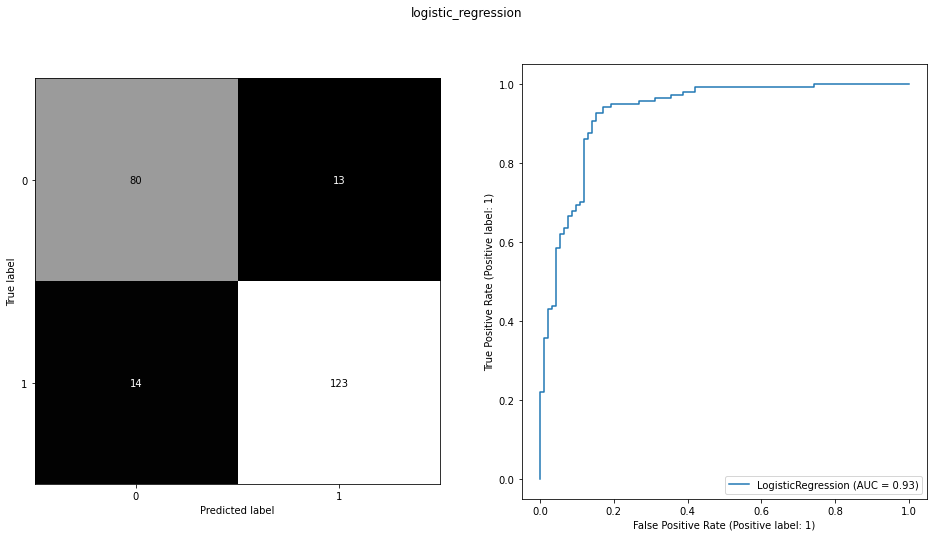

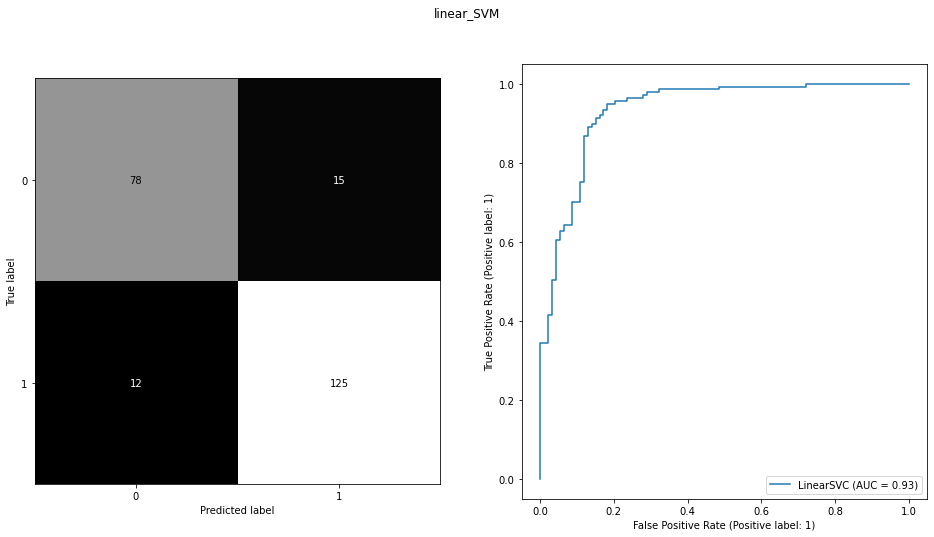

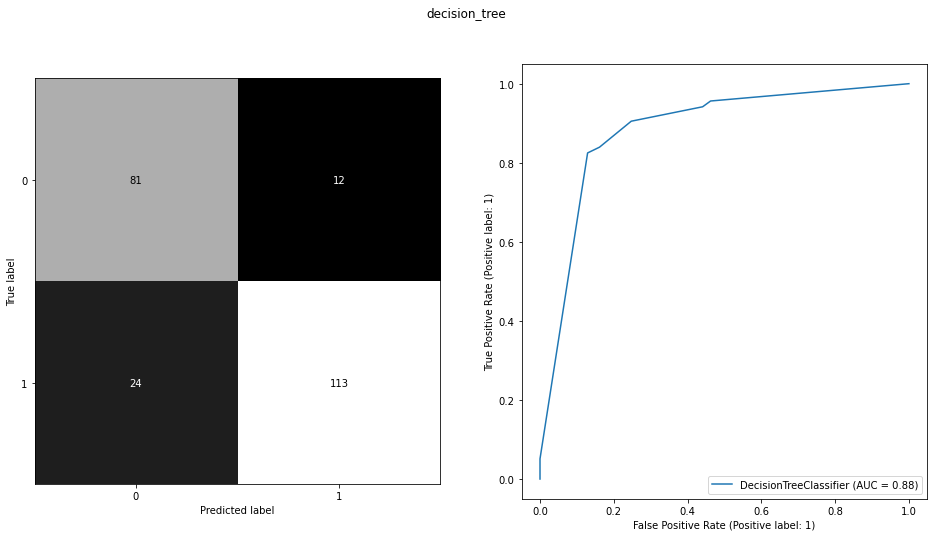

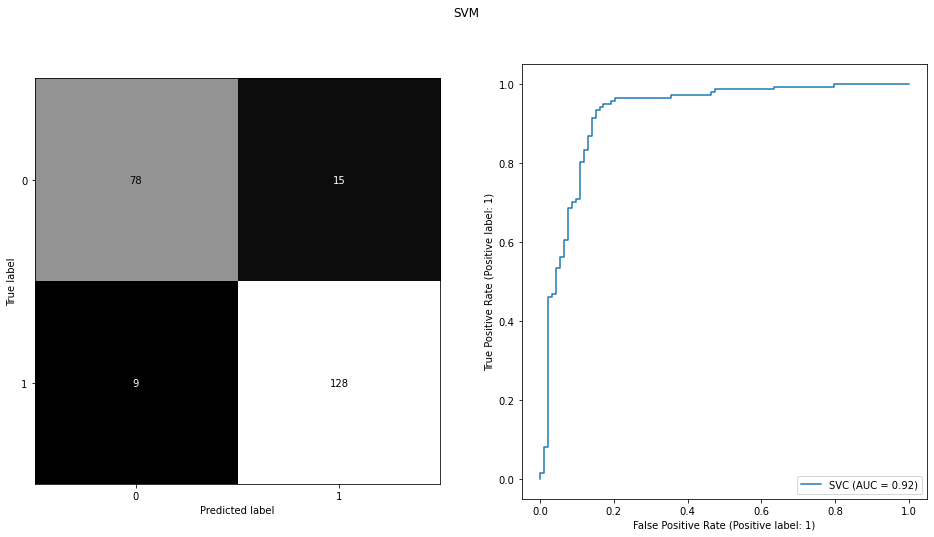

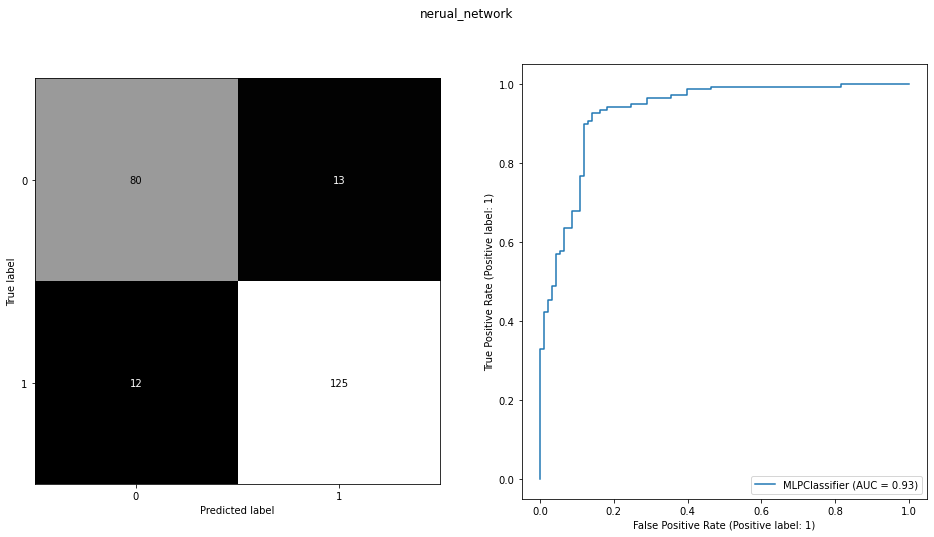

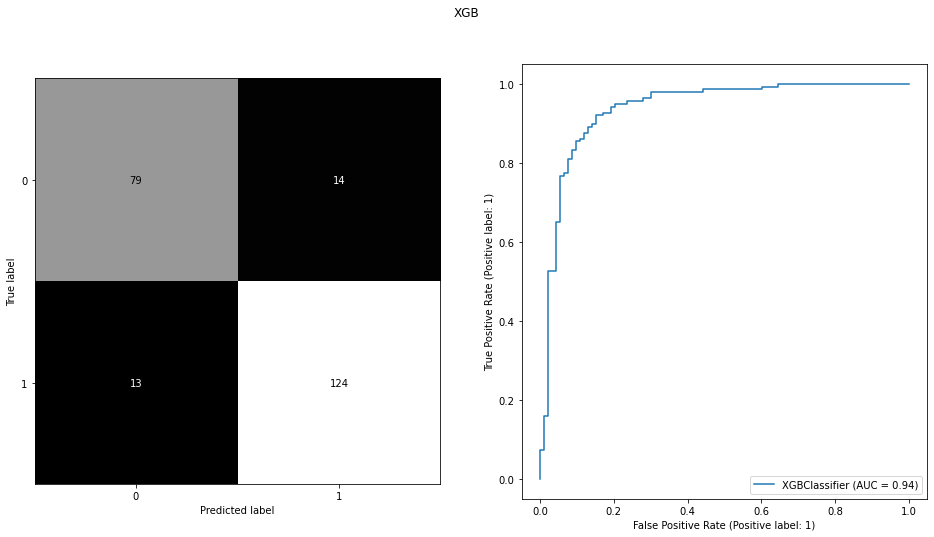

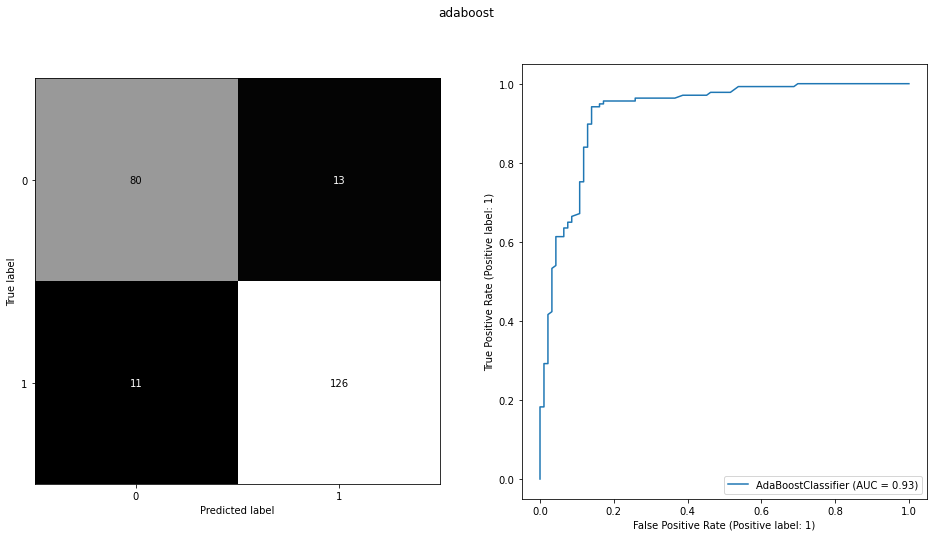

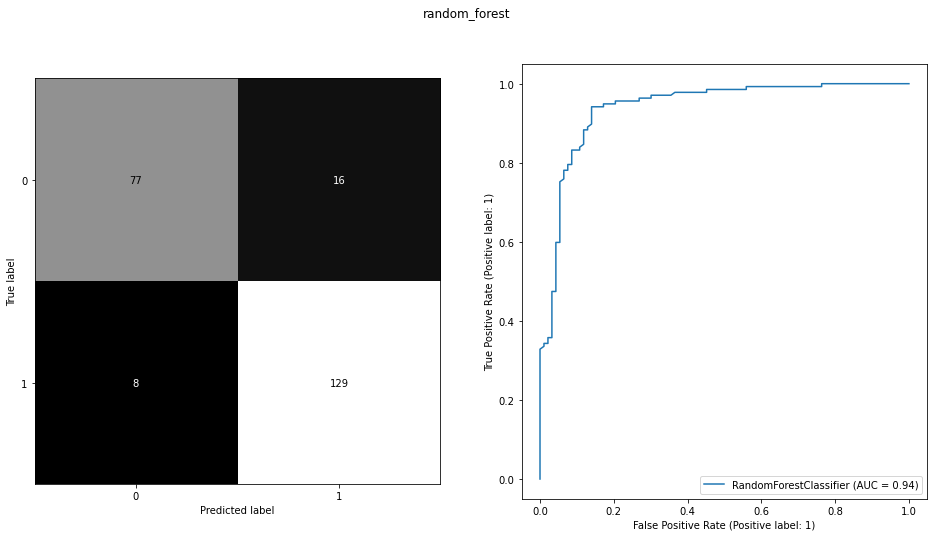

In [34]:
for model_name, model_results in new_results.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(model_name)
    best_estimator = model_results.best_estimator_
    
    plot_confusion_matrix(best_estimator, X_test_transformed, Y_test, cmap='gray', ax=ax1, colorbar=False)
    
    plot_roc_curve(best_estimator,  X_test_transformed, Y_test, ax=ax2)

## Create the final pipeline

In [30]:
final_pipeline = Pipeline([
    ("feature_engineer", feature_engineer_pipeline),
    ("model", RandomForestClassifier(max_depth=20, n_estimators=1232))
])

final_pipeline.fit(X_train, Y_train)
with open("heart_models/final_pipeline.pkl", "wb") as file:
        pickle.dump(final_pipeline, file)